In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import numpy as np
import pmdarima as pm
from scipy.stats import pearsonr
import statsmodels.api
import time

In [2]:
df=pd.read_csv('./data/data_filled.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420285 entries, 0 to 420284
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    420285 non-null  int64  
 1   Store         420285 non-null  int64  
 2   Dept          420285 non-null  int64  
 3   Date          420285 non-null  object 
 4   Weekly_Sales  420285 non-null  float64
 5   IsHoliday     420285 non-null  bool   
 6   Type          420285 non-null  object 
 7   Size          420285 non-null  int64  
 8   Temperature   420285 non-null  float64
 9   Fuel_Price    420285 non-null  float64
 10  MarkDown1     150948 non-null  float64
 11  MarkDown2     150948 non-null  float64
 12  MarkDown3     150948 non-null  float64
 13  MarkDown4     150948 non-null  float64
 14  MarkDown5     150948 non-null  float64
 15  CPI           420285 non-null  float64
 16  Unemployment  420285 non-null  float64
dtypes: bool(1), float64(10), int64(4), object(2)
mem

In [6]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [93]:
df['Date']=pd.to_datetime(df['Date'])
df['IsHoliday']=df['IsHoliday'].astype('int')
# df['year']=df['Date'].dt.year
# df['week']=df['Date'].dt.isocalendar().week

In [209]:
stores=sorted(df['Store'].unique())
departments=sorted(df['Dept'].unique())

p_val_Holiday=[]
p_val_temp=[]
p_val_CPI=[]
p_val_FuelPrice=[]
p_val_Unemployment=[]
stores_tests=[]
departments_tests=[]

for store in stores:
    for department in departments:
        try:
            X=df.loc[(df['Store']==store) & (df['Dept']==department)][['Date','Weekly_Sales', 'IsHoliday','Temperature', 'Fuel_Price','CPI', 'Unemployment']]
            X=X.set_index('Date')
            X_historical=X.loc[X.index < '2011-11-01']
            X_forecast=X.loc[X.index > '2011-11-01']

            result=statsmodels.formula.api.ols(f'Weekly_Sales ~ IsHoliday',data=X_historical).fit()
            anova=statsmodels.api.stats.anova_lm(result)
            p_val_Holiday.append(round(anova['PR(>F)'].iloc[0],3))

            p_val_temp.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Temperature'])[1],3))
            p_val_CPI.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['CPI'])[1],3))
            p_val_FuelPrice.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Fuel_Price'])[1],3))
            p_val_Unemployment.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Unemployment'])[1],3))

            stores_tests.append(store)
            departments_tests.append(department)
        except:
            None

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\126125045.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_val_Unemployment.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Unemployment'])[1],3))
C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\126125045.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_val_Unemployment.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Unemployment'])[1],3))
C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\126125045.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_val_Unemployment.append(round(pearsonr(X_historical['Weekly_Sales'],X_historical['Unemployment'])[1],3))
C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\126125045.py:27: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_val_Unemp

In [210]:
models=pd.DataFrame(list(zip(stores_tests,departments_tests,p_val_Holiday,p_val_temp,p_val_CPI,p_val_FuelPrice,p_val_Unemployment)),
             columns=['Store','Dept','p_val_Holiday','p_val_temp','p_val_CPI','p_val_FuelPrice','p_val_Unemployment'])

In [222]:
models['Holiday_corr']=models['p_val_Holiday'].apply(lambda x: 1 if x < 0.01 else 0)
models['Temp_corr']=models['p_val_temp'].apply(lambda x: 1 if x < 0.01 else 0)
models['CPI_corr']=models['p_val_CPI'].apply(lambda x: 1 if x < 0.01 else 0)
models['FuelPrice_corr']=models['p_val_FuelPrice'].apply(lambda x: 1 if x < 0.01 else 0)
models['Unemployment_corr']=models['p_val_Unemployment'].apply(lambda x: 1 if x < 0.01 else 0)

models['count_corr']=models[['Holiday_corr', 'Temp_corr','CPI_corr', 'FuelPrice_corr', 'Unemployment_corr']].sum(axis=1)

In [242]:
models_selection=models.loc[(models['Store']==1) | (models['Dept']==28) | (models['Dept']==22)]

In [247]:
prediction_results=['SARIMA_model','SARIMA_RMSE','SARIMAX_model','SARIMAX_RMSE','best']

for res in prediction_results:
    models_selection[res]=np.nan

C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\689454499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_selection[res]=np.nan
C:\Users\Guillermo\AppData\Local\Temp\ipykernel_13932\689454499.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  models_selection[res]=np.nan


In [299]:
time_start = time.time()

for i in models_selection.index:

    print('#'*20, i, '#'*20)

    if models_selection.loc[i]['count_corr']==0:
        try:
            X=df.loc[(df['Store']==models_selection.loc[i]['Store']) & 
                    (df['Dept']==models_selection.loc[i]['Dept'])][['Date','Weekly_Sales']]
            X=X.set_index('Date') 
            
            y_historical=X.loc[X.index < '2011-11-01']['Weekly_Sales']
            y_forecast=X.loc[X.index > '2011-11-01']['Weekly_Sales']

            smodel = pm.auto_arima(y_historical, start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=52,
                            start_P=0, seasonal=True,
                            d=0, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
            
            prediction = smodel.predict(n_periods=len(y_forecast))

            RMSE=round(np.sqrt(mean_squared_error(y_forecast,prediction)))

            models_selection.loc[i,'SARIMA_model']=smodel
            models_selection.loc[i,'SARIMA_RMSE']=RMSE
            models_selection.loc[i,'best']='SARIMA'

        except:
            print(f'Error in Store {models_selection.loc[i]['Store']} - Department {models_selection.loc[i]['Dept']}')

    else:
        try:
            corr_feats=[]
            if models_selection.loc[i]['Holiday_corr']==1:
                corr_feats.append('IsHoliday')

            if models_selection.loc[i]['Temp_corr']==1:
                corr_feats.append('Temperature')

            if models_selection.loc[i]['CPI_corr']==1:
                corr_feats.append('CPI')
            
            if models_selection.loc[i]['FuelPrice_corr']==1:
                corr_feats.append('Fuel_Price')
            
            if models_selection.loc[i]['Unemployment_corr']==1:
                corr_feats.append('Unemployment')

            X=df.loc[(df['Store']==models_selection.loc[i]['Store']) & 
                    (df['Dept']==models_selection.loc[i]['Dept'])][['Date','Weekly_Sales']+corr_feats]
            X=X.set_index('Date') 

            X_historical=X.loc[X.index<'2011-11-01']
            X_forecast=X.loc[X.index>'2011-11-01']

            y_historical=X_historical['Weekly_Sales']
            y_forecast=X_forecast['Weekly_Sales']

            X_historical=X_historical.drop('Weekly_Sales',axis=1)
            X_forecast=X_forecast.drop('Weekly_Sales',axis=1)

            smodel = pm.auto_arima(y_historical, start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=52,
                            start_P=0, seasonal=True,
                            d=0, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
            
            prediction = smodel.predict(n_periods=len(y_forecast))

            RMSE=round(np.sqrt(mean_squared_error(y_forecast,prediction)))

            models_selection.loc[i,'SARIMA_model']=smodel
            models_selection.loc[i,'SARIMA_RMSE']=RMSE

            sxmodel = pm.auto_arima(y_historical,
                        X=X_historical, start_p=1, start_q=1,
                            test='adf',
                            max_p=3, max_q=3, m=52,
                            start_P=0, seasonal=True,
                            d=0, D=1, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
            
            prediction = sxmodel.predict(n_periods=len(y_forecast),X=X_forecast)

            RMSE=round(np.sqrt(mean_squared_error(y_forecast,prediction)))

            models_selection.loc[i,'SARIMAX_model']=sxmodel
            models_selection.loc[i,'SARIMAX_RMSE']=RMSE        

            if models_selection.loc[i]['SARIMA_RMSE'] > models_selection.loc[i]['SARIMAX_RMSE']:
                models_selection.loc[i,'best']='SARIMAX'
            else:
                models_selection.loc[i,'best']='SARIMA'

        except:
            print(f'Error in Store {models_selection.loc[i]['Store']} - Department {models_selection.loc[i]['Dept']}')

time_elapsed = (time.time() - time_start)
print(f'Time spent:{time_elapsed}')



#################### 0 ####################
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=813.610, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=832.845, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=4.03 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=813.393, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=831.222, Time=0.10 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=815.255, Time=0.18 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=7.18 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=815.382, Time=2.86 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=813.264, Time=0.93 sec
 ARIMA(0,0,1)(2,1,0)[52] intercept   : AIC=815.254, Time=2.89 sec
 ARIMA(0,0,1)(2,1,1)[52] intercept   : AIC=inf, Time=15.96 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=832.514, Time=0.51 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=813.359, Time=1.42 sec
 ARIMA(0,0,2)(1,1,0)[52] intercept   : AIC=814.844, Time=1.10 sec


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=5.97 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=371.644, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=27.35 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=6.12 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=406.651, Time=0.04 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=373.308, Time=0.44 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=373.140, Time=0.77 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=10.79 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=373.040, Time=0.30 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=371.840, Time=0.53 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=373.533, Time=0.80 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 53.241 seconds
#################### 17 ####################
Performing stepwise search to minimize aic


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.59 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=580.918, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=4.49 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=618.295, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=579.902, Time=5.42 sec
 ARIMA(0,0,0)(2,1,1)[52] intercept   : AIC=inf, Time=14.68 sec
 ARIMA(0,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=14.84 sec
 ARIMA(0,0,0)(0,1,2)[52] intercept   : AIC=inf, Time=12.37 sec
 ARIMA(0,0,0)(2,1,0)[52] intercept   : AIC=inf, Time=11.77 sec
 ARIMA(0,0,0)(2,1,2)[52] intercept   : AIC=inf, Time=19.10 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=578.375, Time=5.92 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=579.50

c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=8.000, Time=1.24 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=31.514, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=28.376, Time=0.10 sec


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=6.000, Time=0.20 sec


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=8.000, Time=1.11 sec


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=10.000, Time=1.41 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=29.514, Time=0.16 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,0,0)(0,1,0)[52]             : AIC=29.217, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,1,0)[52] intercept
Total fit time: 8.786 seconds
Error in Store 1 - Department 45
#################### 42 ####################
Performing stepwise search to minimize aic


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=5.62 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=667.559, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=673.309, Time=0.96 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=671.885, Time=0.86 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=679.346, Time=0.13 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=669.547, Time=0.40 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=669.546, Time=0.40 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=669.033, Time=0.55 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=669.053, Time=0.44 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=671.324, Time=0.68 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 13.617 seconds
#################### 43 ####################
Error in Store 1 - Department 47
#################### 44 ####################
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   

c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#################### 45 ####################
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=699.998, Time=5.41 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=704.061, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=707.663, Time=0.94 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=707.144, Time=0.93 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=702.565, Time=0.09 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=707.065, Time=0.45 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=701.548, Time=7.69 sec
 ARIMA(1,0,1)(0,1,2)[52] intercept   : AIC=701.573, Time=10.03 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=697.834, Time=5.90 sec
 ARIMA(1,0,1)(2,1,0)[52] intercept   : AIC=701.452, Time=18.91 sec
 ARIMA(1,0,1)(2,1,1)[52] intercept   : AIC=inf, Time=18.15 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=695.996, Time=4.31 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=706.222, Time=0.17 sec
 ARIMA(0,0,1)(2,1,0)[52] intercept   : AIC=708.682, Tim

c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.95 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=387.660, Time=0.51 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=7.04 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.61 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=402.799, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=5.81 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=4.56 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=9.81 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=390.945, Time=1.04 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=390.682, Time=1.32 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=399.616, Time=1.56 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 51.478 seconds
#################### 49 ####################
Performing stepwise search to minimize aic


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=702.161, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=699.555, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=700.718, Time=0.86 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=700.692, Time=2.03 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=710.130, Time=0.74 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=701.289, Time=1.00 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=701.342, Time=0.53 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=4.54 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=699.394, Time=0.47 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=700.799, Time=0.99 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=5.62 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=700.526, Time=0.17 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=700.163, Time=0.20 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=698.737, Time=0.82 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=700.674, Time=1.32 sec
 ARIMA(0,0,1)(1,1,

c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=9.45 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=374.209, Time=0.15 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=9.51 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.83 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=372.209, Time=0.40 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=8.52 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=6.91 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=378.149, Time=9.96 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=375.654, Time=0.60 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=375.797, Time=1.18 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=377.111, Time=1.79 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52]          
Total fit time: 56.315 seconds
#################### 3106 ####################
Performing stepwise search to minimize aic


c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Guillermo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=4.80 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=472.425, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=6.14 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=470.910, Time=0.10 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=473.170, Time=0.23 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=472.922, Time=0.28 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=474.489, Time=0.59 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52]          
Total fit time: 28.566 seconds
#################### 3159 ####################
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=675.014, Time=5.04 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=677.800, Time=0.04 s

In [574]:
models_selection.head()

,Store,Dept,p_val_Holiday,p_val_temp,p_val_CPI,p_val_FuelPrice,p_val_Unemployment,Holiday_corr,Temp_corr,CPI_corr,...,count_corr,SARIMA_model,SARIMA_pred,SARIMA_RMSE,SARIMAX_model,SARIMAX_pred,SARIMAX_RMSE,best,Mean_Weekly_Sales,mean_error
0,1,1,0.300,0.000,0.267,0.252,0.761,0,1,0,...,1,"ARIMA(2,0,0)(1,1,0)[52]",NaN,7473.0,"ARIMA(2,0,0)(2,1,0)[52] intercept",NaN,7112.0,SARIMAX,22513.322937,0.315902
1,1,2,0.114,0.625,0.665,0.692,0.728,0,0,0,...,0,"ARIMA(2,0,1)(0,1,0)[52] intercept",NaN,3173.0,NaN,NaN,NaN,SARIMA,46102.090420,0.068826
2,1,3,0.580,0.001,0.545,0.945,0.109,0,1,0,...,1,"ARIMA(1,0,1)(0,1,0)[52] intercept",NaN,4819.0,"ARIMA(0,0,0)(0,1,0)[52]",NaN,4884.0,SARIMA,13150.478042,0.366451
3,1,4,0.104,0.745,0.156,0.228,0.954,0,0,0,...,0,"ARIMA(1,0,0)(0,1,0)[52]",NaN,2587.0,NaN,NaN,NaN,SARIMA,36964.154476,0.069987
4,1,5,0.011,0.000,0.165,0.127,0.256,0,1,0,...,1,"ARIMA(0,0,0)(0,1,0)[52]",NaN,6248.0,"ARIMA(0,0,0)(0,1,0)[52] intercept",NaN,6405.0,SARIMA,24257.941119,0.257565


In [311]:
for i in models_selection.index:
    models_selection.loc[i,'Mean_Weekly_Sales']=df.loc[(df['Store']==models_selection.loc[i,'Store']) 
            & (df['Dept']==models_selection.loc[i,'Dept'])]['Weekly_Sales'].mean()
    
models_selection['mean_error']=models_selection[['SARIMA_RMSE','SARIMAX_RMSE']].min(axis=1)/models_selection['Mean_Weekly_Sales']


In [578]:
department_stats=models_selection.loc[models_selection['Dept']==22][['Store','Dept','SARIMA_RMSE','SARIMAX_RMSE','best','mean_error']]
department_stats.dropna(subset='SARIMA_RMSE',inplace=True)
department_stats['mean_error']=department_stats['mean_error'].apply(lambda x: round(x*100,2))
department_stats['type']=department_stats[['SARIMA_RMSE','SARIMAX_RMSE','best']]\
    .apply(lambda x: x['best'] if (x['best']=='SARIMAX') | (np.isnan(x['SARIMAX_RMSE'])) else 'SARIMA(x)',axis=1)
department_stats

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
20,1,22,2090.00000,1684.0,SARIMAX,20.91,SARIMAX
96,2,22,2650.00000,2188.0,SARIMAX,16.93,SARIMAX
173,3,22,1231.00000,1103.0,SARIMAX,35.56,SARIMAX
242,4,22,2124.00000,6335.0,SARIMA,12.28,SARIMA(x)
318,5,22,821.00000,1150.0,SARIMA,33.79,SARIMA(x)
388,6,22,2685.00000,3760.0,SARIMA,14.26,SARIMA(x)
464,7,22,1910.00000,1899.0,SARIMAX,27.87,SARIMAX
537,8,22,1413.00000,2327.0,SARIMA,19.80,SARIMA(x)
611,9,22,1277.00000,1226.0,SARIMAX,24.81,SARIMAX
682,10,22,3339.00000,6385.0,SARIMA,13.03,SARIMA(x)


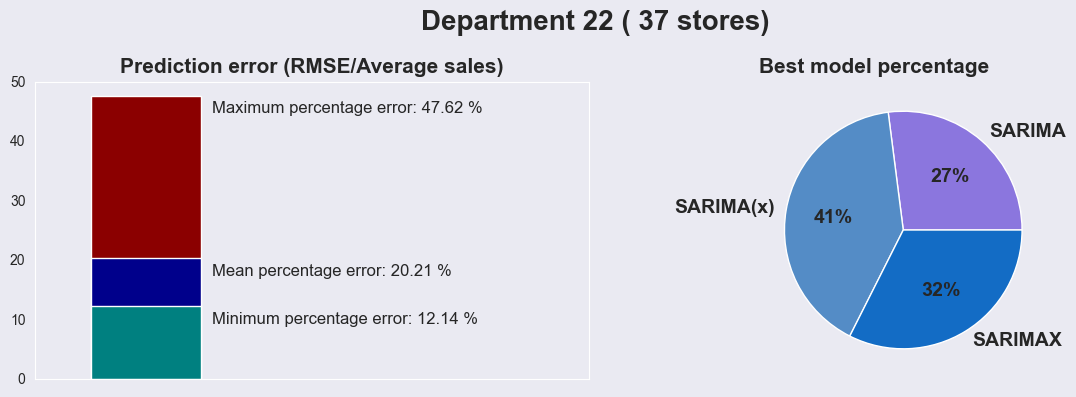

In [416]:

sns.set_style('dark')
fig=plt.figure(figsize=(12,4))
fig.patch.set_facecolor('#EAEAF2')
plt.subplot(121)
plt.title('Prediction error (RMSE/Average sales)',fontsize=15,fontweight='semibold')
plt.bar(0,department_stats['mean_error'].max(),color='darkred',width=0.5)
plt.text(0.3,department_stats['mean_error'].max()-3,f'Maximum percentage error: {department_stats['mean_error'].max()} %',fontsize=12)

plt.bar(0,department_stats['mean_error'].mean(),color='darkblue',width=0.5)
plt.text(0.3,department_stats['mean_error'].mean()-3,f'Mean percentage error: {department_stats['mean_error'].mean()} %',fontsize=12)

plt.bar(0,department_stats['mean_error'].min(),color='teal',width=0.5)
plt.text(0.3,department_stats['mean_error'].min()-3,f'Minimum percentage error: {department_stats['mean_error'].min()} %',fontsize=12)

plt.xlim(-0.5,2)

plt.xticks([])

plt.subplot(122)
plt.title('Best model percentage          ',fontsize=15,fontweight='semibold')
plt.pie(department_stats['type'].value_counts().sort_index(),labels=department_stats['type'].value_counts().sort_index().index,
        colors=['#8B76DE','#548CC6','#136CC5'],
        autopct='%1.0f%%', pctdistance=0.6, textprops={'fontsize': 14,'fontweight':'semibold'})

plt.suptitle(f'Department 22 ( {department_stats.shape[0]} stores)',fontsize=20,fontweight='semibold')

plt.tight_layout()
plt.show()

In [443]:
department_stats.loc[department_stats['Store']==2]['type'].values[0]

'SARIMAX'

In [467]:

def prediction_plot(department,store_number):

    model_type=department_stats.loc[department_stats['Store']==store_number]['type'].values[0]

    if model_type == 'SARIMA':
        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model']

        X=df.loc[(df['Store']==store_number) & (df['Dept']==department)]\
            [['Date','Weekly_Sales']]
        X=X.set_index('Date')

        y_historical=X.loc[X.index<'2011-11-01']['Weekly_Sales']
        y_forecast=X.loc[X.index>'2011-11-01']['Weekly_Sales']

        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model'].values[0]

        sarima_pred=smodel.predict(n_periods=len(y_forecast))
        sarima_pred=pd.Series(sarima_pred, index=y_forecast.index)

        plt.figure(figsize=(12,5))
        plt.plot(y_historical,'teal',label='Historical')
        plt.plot(y_forecast,'teal',alpha=0.4)
        plt.plot(sarima_pred,'--',label='Prediction')
        plt.ylabel('Weekly Sales')
        plt.legend(fontsize=12)
        plt.title(f'Department {department} - Store {store_number} (Best model: {model_type})',fontsize=15, fontweight='semibold')   
        plt.tight_layout()     
        plt.show()        

    else:
        
        i=department_stats.loc[(department_stats['Store']==store_number) & (department_stats['Store']==store_number)].index.values[0]
        print(i)
        corr_feats=[]
        if models_selection.loc[i]['Holiday_corr']==1:
            corr_feats.append('IsHoliday')

        if models_selection.loc[i]['Temp_corr']==1:
            corr_feats.append('Temperature')

        if models_selection.loc[i]['CPI_corr']==1:
            corr_feats.append('CPI')
        
        if models_selection.loc[i]['FuelPrice_corr']==1:
            corr_feats.append('Fuel_Price')
        
        if models_selection.loc[i]['Unemployment_corr']==1:
            corr_feats.append('Unemployment')

        X=df.loc[(df['Store']==store_number) & 
                (df['Dept']==department)][['Date','Weekly_Sales']+corr_feats]
        X=X.set_index('Date') 

        X_historical=X.loc[X.index<'2011-11-01']
        X_forecast=X.loc[X.index>'2011-11-01']

        y_historical=X_historical['Weekly_Sales']
        y_forecast=X_forecast['Weekly_Sales']

        X_historical=X_historical.drop('Weekly_Sales',axis=1)
        X_forecast=X_forecast.drop('Weekly_Sales',axis=1)

        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model'].values[0]
        sxmodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMAX_model'].values[0]

        sarima_pred=smodel.predict(n_periods=len(y_forecast))
        sarimax_pred=sxmodel.predict(n_periods=len(y_forecast),X=X_forecast)

        sarima_pred = pd.Series(sarima_pred, index=y_forecast.index)
        sarimax_pred = pd.Series(sarimax_pred, index=y_forecast.index)

        if model_type == 'SARIMA(x)':

            plt.figure(figsize=(12,5))
            plt.plot(y_historical,'teal',label='Historical')
            plt.plot(y_forecast,'teal',alpha=0.6)
            plt.plot(sarima_pred,'--',label='Prediction (SARIMA)',color='darkblue')
            plt.plot(sarimax_pred,'--',label='Prediction (SARIMAX)',alpha=0.4,color='darkblue')
            plt.ylabel('Weekly Sales')
            plt.legend(fontsize=12)
            plt.title(f'Department {department} - Store {store_number} (Best model: SARIMA)',fontsize=15, fontweight='semibold')   
            plt.tight_layout()     
            plt.show()  

        else:

            plt.figure(figsize=(12,5))
            plt.plot(y_historical,'teal',label='Historical')
            plt.plot(y_forecast,'teal',alpha=0.6)
            plt.plot(sarimax_pred,'--',label='Prediction (SARIMAX)',color='darkblue')
            plt.plot(sarima_pred,'--',label='Prediction (SARIMA)',alpha=0.4,color='darkblue')
            plt.ylabel('Weekly Sales')
            plt.legend(fontsize=12)
            plt.title(f'Department {department} - Store {store_number} (Best model: SARIMAX)',fontsize=15, fontweight='semibold')   
            plt.tight_layout()     
            plt.show() 



In [469]:
department_stats.loc[(department_stats['mean_error']==department_stats['mean_error'].min()) |
                     (department_stats['mean_error']==department_stats['mean_error'].max())]

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
1651,23,22,2694.0,NaN,SARIMA,12.14,SARIMA
2765,39,22,6197.0,NaN,SARIMA,47.62,SARIMA


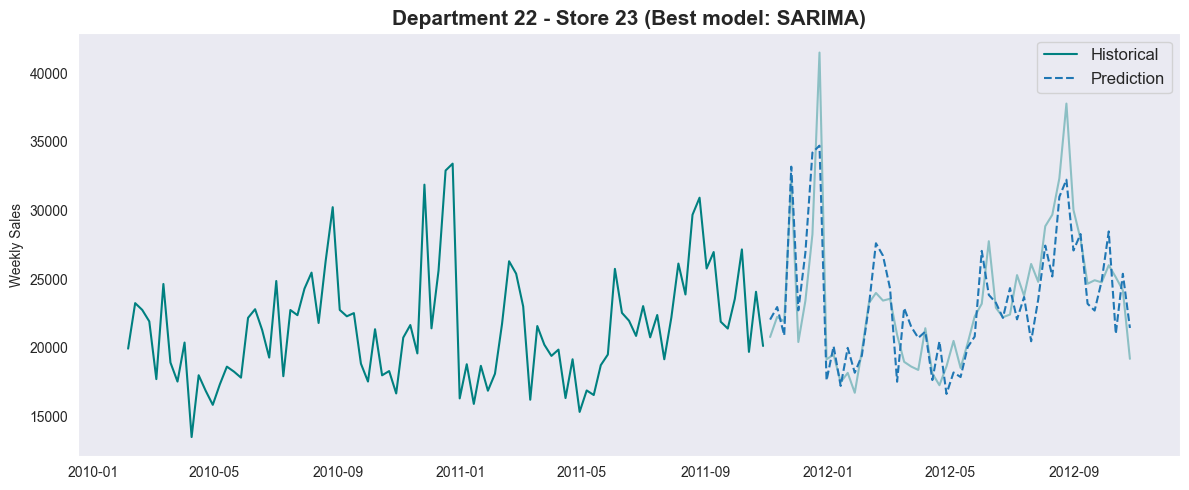

In [470]:
prediction_plot(department=22,store_number=23)

In [593]:
smodel=models_selection.loc[(models_selection['Store']==23) & (models_selection['Dept']==22),'SARIMA_model']

X=df.loc[(df['Store']==23) & (df['Dept']==22)]\
[['Date','Weekly_Sales']]
X=X.set_index('Date')

y_historical=X.loc[X.index<'2011-11-01']['Weekly_Sales']
y_forecast=X.loc[X.index>'2011-11-01']['Weekly_Sales']

smodel=models_selection.loc[(models_selection['Store']==23) & (models_selection['Dept']==22),'SARIMA_model'].values[0]

sarima_pred=smodel.predict(n_periods=len(y_forecast))
sarima_pred=pd.DataFrame(list(zip(sarima_pred,y_forecast.values)),columns=['Prediction','Real'],index=y_forecast.index)
sarima_pred['Diff']=sarima_pred['Prediction']-sarima_pred['Real']
sarima_pred

,Prediction,Real,Diff
Date,,,
2011-11-04,22042.487179,20775.43,1267.057179
2011-11-11,22956.907179,22243.86,713.047179
2011-11-18,20889.977179,21904.58,-1014.602821
2011-11-25,33186.177179,32233.00,953.177179
2011-12-02,22716.797179,20410.24,2306.557179
2011-12-09,26925.317179,23410.70,3514.617179
2011-12-16,34216.577179,28262.91,5953.667179
2011-12-23,34717.827179,41501.25,-6783.422821
2011-12-30,17611.537179,19145.86,-1534.322821


In [589]:
y_forecast.values

array([20775.43, 22243.86, 21904.58, 32233.  , 20410.24, 23410.7 ,
       28262.91, 41501.25, 19145.86, 19494.32, 17473.76, 18160.33,
       16711.92, 19735.53, 23240.69, 23985.72, 23427.53, 23559.34,
       20933.04, 18964.73, 18619.86, 18373.78, 21412.76, 18123.82,
       17259.57, 18632.37, 20489.67, 18520.18, 20314.43, 22274.19,
       23199.03, 27754.29, 22907.95, 22216.25, 22410.47, 25285.05,
       23776.43, 26097.24, 24794.63, 28843.9 , 29682.67, 32339.11,
       37783.85, 30032.35, 27911.3 , 24655.91, 24910.45, 24755.37,
       26006.65, 25128.35, 24174.9 , 19183.85])

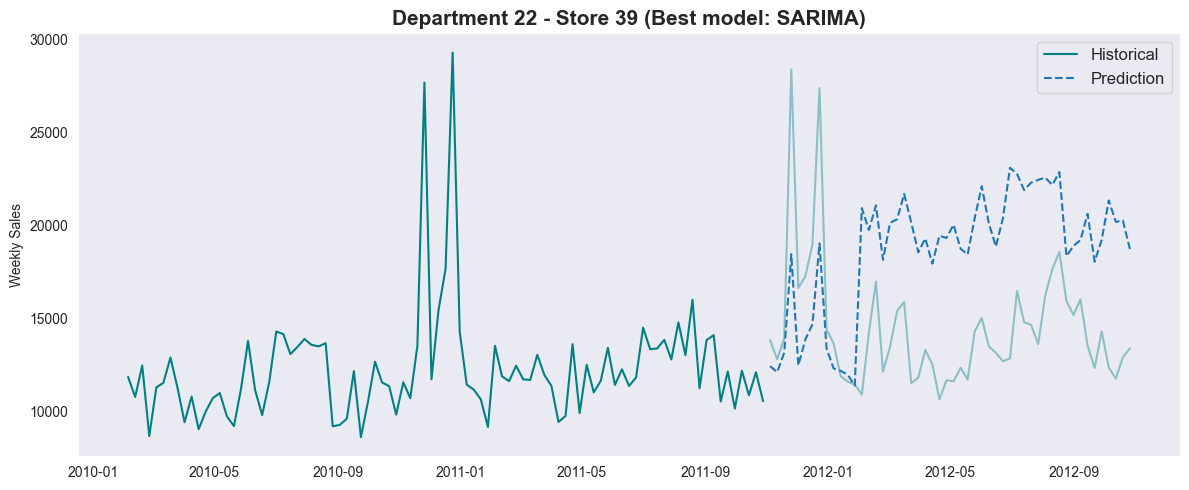

In [471]:
prediction_plot(department=22,store_number=39)

In [558]:
models_selection.loc[2765]

Store                                                 39
Dept                                                  22
p_val_Holiday                                      0.036
p_val_temp                                         0.972
p_val_CPI                                          0.955
p_val_FuelPrice                                    0.792
p_val_Unemployment                                 0.881
Holiday_corr                                           0
Temp_corr                                              0
CPI_corr                                               0
FuelPrice_corr                                         0
Unemployment_corr                                      0
count_corr                                             0
SARIMA_model           ARIMA(1,0,1)(1,1,0)[52] intercept
SARIMA_pred                                          NaN
SARIMA_RMSE                                       6197.0
SARIMAX_model                                        NaN
SARIMAX_pred                   

In [571]:
X=df.loc[(df['Store']==39) & (df['Dept']==22)][['Date','Weekly_Sales', 'IsHoliday']]
X=X.set_index('Date')

X_historical=X.loc[X.index<'2011-11-01']
X_forecast=X.loc[X.index>'2011-11-01']

y_historical=X_historical['Weekly_Sales']
y_forecast=X_forecast['Weekly_Sales']

X_historical=X_historical.drop('Weekly_Sales',axis=1)
X_forecast=X_forecast.drop('Weekly_Sales',axis=1)

correction_ = pm.auto_arima(y_historical,
                         start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=52,
                         start_P=0, seasonal=True,
                         start_d=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1731.731, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1712.941, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1729.738, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1716.585, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=1706.771, Time=6.65 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=12.31 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=1724.473, Time=6.34 sec
 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=1711.403, Time=2.97 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=inf, Time=16.09 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=1692.632, Time=11.76 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1690.632, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AI

In [572]:
correction_pred=correction_.predict(len(y_forecast))

np.sqrt(mean_squared_error(correction_pred,y_forecast))

1960.1728595947222

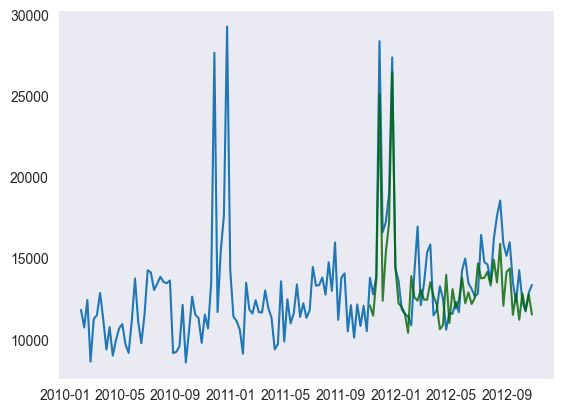

In [573]:
fitted_series= pd.DataFrame(correction_pred,index=y_forecast.index)
plt.plot(X['Weekly_Sales'])
plt.plot(fitted_series, color='darkgreen',alpha=0.8)

In [576]:
models_selection.loc[2765,'SARIMA_model']=correction_
models_selection.loc[2765,'SARIMA_RMSE']=np.sqrt(mean_squared_error(correction_pred,y_forecast))
models_selection.loc[2765,'mean_error']=models_selection.loc[2765,'SARIMA_RMSE']/models_selection.loc[2765,'Mean_Weekly_Sales']
models_selection.loc[2765]

Store                                                 39
Dept                                                  22
p_val_Holiday                                      0.036
p_val_temp                                         0.972
p_val_CPI                                          0.955
p_val_FuelPrice                                    0.792
p_val_Unemployment                                 0.881
Holiday_corr                                           0
Temp_corr                                              0
CPI_corr                                               0
FuelPrice_corr                                         0
Unemployment_corr                                      0
count_corr                                             0
SARIMA_model           ARIMA(1,1,2)(1,0,0)[52]          
SARIMA_pred                                          NaN
SARIMA_RMSE                                   1960.17286
SARIMAX_model                                        NaN
SARIMAX_pred                   

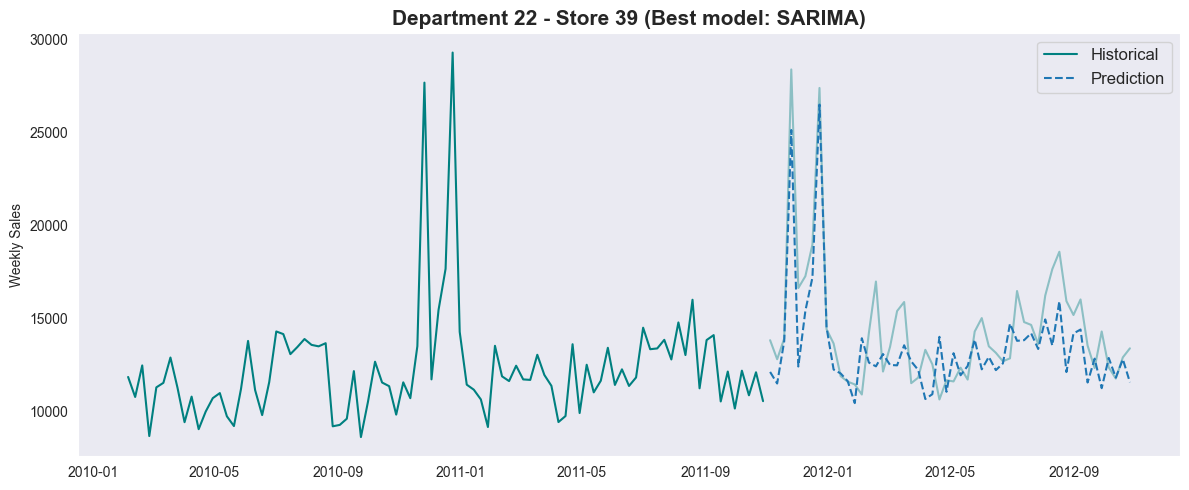

In [579]:
prediction_plot(department=22,store_number=39)

In [594]:
department_stats=models_selection.loc[models_selection['Dept']==28][['Store','Dept','SARIMA_RMSE','SARIMAX_RMSE','best','mean_error']]
department_stats.dropna(subset='SARIMA_RMSE',inplace=True)
department_stats['mean_error']=department_stats['mean_error'].apply(lambda x: round(x*100,2))
department_stats['type']=department_stats[['SARIMA_RMSE','SARIMAX_RMSE','best']]\
    .apply(lambda x: x['best'] if (x['best']=='SARIMAX') | (np.isnan(x['SARIMAX_RMSE'])) else 'SARIMA(x)',axis=1)
department_stats

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
26,1,28,180.0,347.0,SARIMA,30.35,SARIMA(x)
102,2,28,266.0,688.0,SARIMA,33.30,SARIMA(x)
179,3,28,68.0,79.0,SARIMA,40.75,SARIMA(x)
248,4,28,190.0,198.0,SARIMA,20.74,SARIMA(x)
324,5,28,68.0,87.0,SARIMA,33.45,SARIMA(x)
394,6,28,145.0,316.0,SARIMA,25.06,SARIMA(x)
470,7,28,78.0,NaN,SARIMA,40.91,SARIMA
543,8,28,131.0,475.0,SARIMA,41.37,SARIMA(x)
617,9,28,103.0,242.0,SARIMA,41.81,SARIMA(x)
688,10,28,296.0,245.0,SARIMAX,18.46,SARIMAX


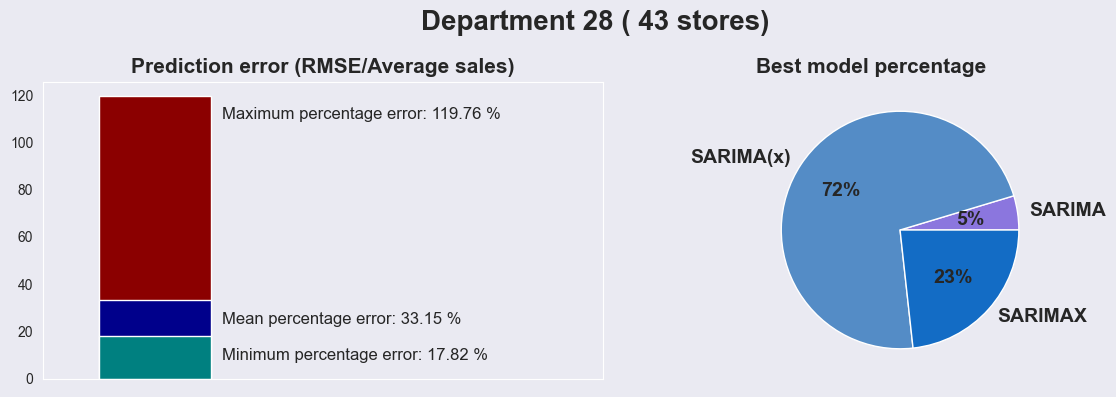

In [475]:

sns.set_style('dark')
fig=plt.figure(figsize=(12,4))
fig.patch.set_facecolor('#EAEAF2')
plt.subplot(121)
plt.title('Prediction error (RMSE/Average sales)',fontsize=15,fontweight='semibold')
plt.bar(0,department_stats['mean_error'].max(),color='darkred',width=0.5)
plt.text(0.3,department_stats['mean_error'].max()-10,f'Maximum percentage error: {department_stats['mean_error'].max()} %',fontsize=12)

plt.bar(0,department_stats['mean_error'].mean(),color='darkblue',width=0.5)
plt.text(0.3,department_stats['mean_error'].mean()-10,f'Mean percentage error: {round(department_stats['mean_error'].mean(),2)} %',fontsize=12)

plt.bar(0,department_stats['mean_error'].min(),color='teal',width=0.5)
plt.text(0.3,department_stats['mean_error'].min()-10,f'Minimum percentage error: {department_stats['mean_error'].min()} %',fontsize=12)

plt.xlim(-0.5,2)

plt.xticks([])

plt.subplot(122)
plt.title('Best model percentage          ',fontsize=15,fontweight='semibold')
plt.pie(department_stats['type'].value_counts().sort_index(),labels=department_stats['type'].value_counts().sort_index().index,
        colors=['#8B76DE','#548CC6','#136CC5'],
        autopct='%1.0f%%', pctdistance=0.6, textprops={'fontsize': 14,'fontweight':'semibold'})

plt.suptitle(f'Department 28 ( {department_stats.shape[0]} stores)',fontsize=20,fontweight='semibold')

plt.tight_layout()
plt.show()

In [476]:
department_stats.loc[(department_stats['mean_error']==department_stats['mean_error'].min()) |
                     (department_stats['mean_error']==department_stats['mean_error'].max())]

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
1212,17,28,230.0,284.0,SARIMA,17.82,SARIMA(x)
3106,44,28,87.0,NaN,SARIMA,119.76,SARIMA


1212


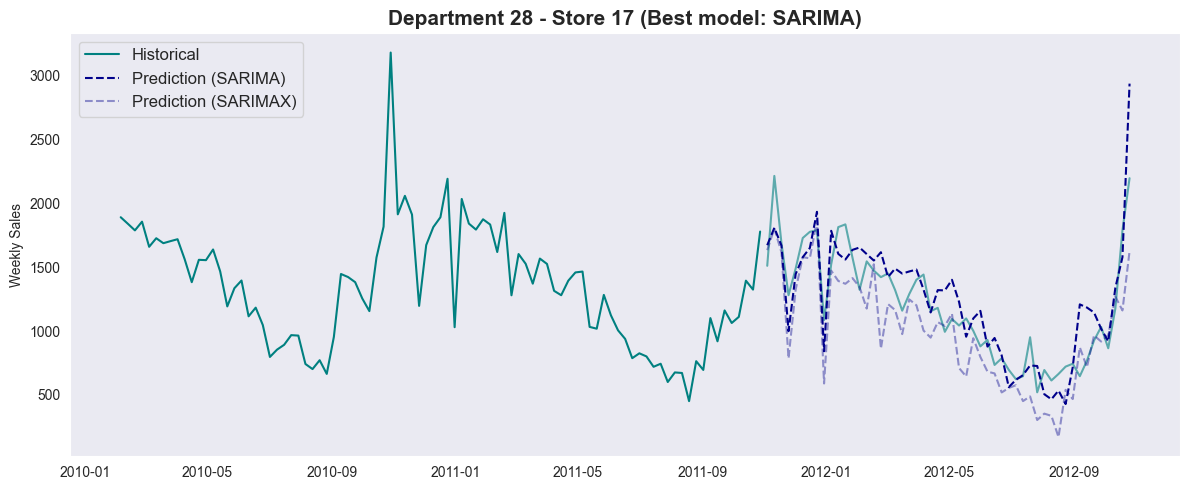

In [478]:
prediction_plot(department=28,store_number=17)

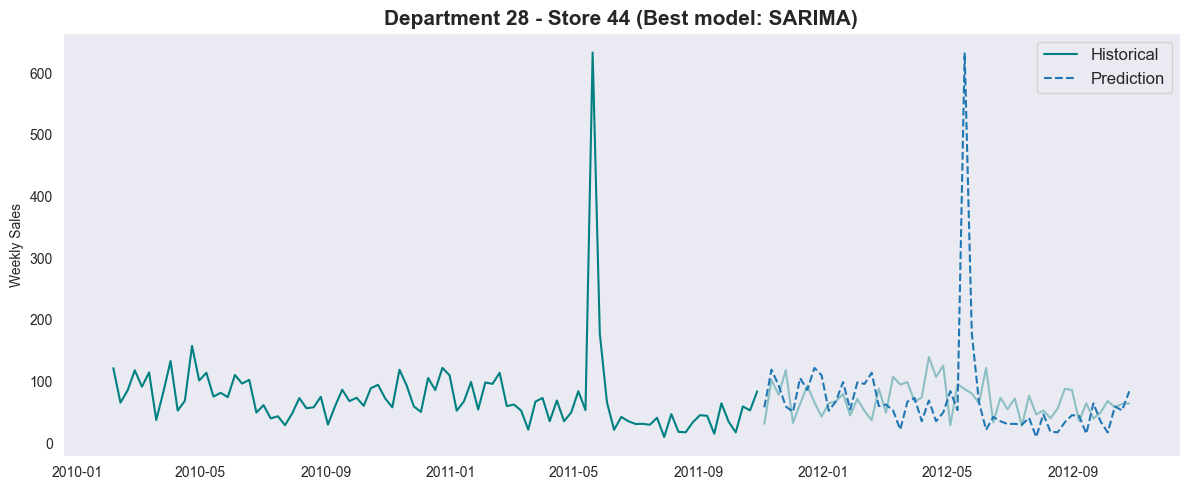

In [479]:
prediction_plot(department=28,store_number=44)

In [595]:
models_selection.loc[3106]

Store                                                 44
Dept                                                  28
p_val_Holiday                                      0.949
p_val_temp                                         0.032
p_val_CPI                                           0.37
p_val_FuelPrice                                    0.659
p_val_Unemployment                                 0.134
Holiday_corr                                           0
Temp_corr                                              0
CPI_corr                                               0
FuelPrice_corr                                         0
Unemployment_corr                                      0
count_corr                                             0
SARIMA_model           ARIMA(0,0,0)(0,1,0)[52]          
SARIMA_pred                                          NaN
SARIMA_RMSE                                         87.0
SARIMAX_model                                        NaN
SARIMAX_pred                   

In [606]:
X=df.loc[(df['Store']==44) & (df['Dept']==28)][['Date','Weekly_Sales', 'IsHoliday']]
X=X.set_index('Date')

X.loc[X.Weekly_Sales==X.Weekly_Sales.max()]



,Weekly_Sales,IsHoliday
Date,,
2011-05-20,633.53,0


In [518]:
store_stats=models_selection.loc[models_selection['Store']==1][['Store','Dept','SARIMA_RMSE','SARIMAX_RMSE','best','mean_error']]
store_stats.dropna(subset='SARIMA_RMSE',inplace=True)
store_stats['mean_error']=store_stats['mean_error'].apply(lambda x: round(x*100,2))
store_stats['type']=store_stats[['SARIMA_RMSE','SARIMAX_RMSE','best']]\
    .apply(lambda x: x['best'] if (x['best']=='SARIMAX') | (np.isnan(x['SARIMAX_RMSE'])) else 'SARIMA(x)',axis=1)
store_stats.drop(48,inplace=True)
store_stats

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
0,1,1,7473.0,7112.0,SARIMAX,31.59,SARIMAX
1,1,2,3173.0,NaN,SARIMA,6.88,SARIMA
2,1,3,4819.0,4884.0,SARIMA,36.65,SARIMA(x)
3,1,4,2587.0,NaN,SARIMA,7.00,SARIMA
4,1,5,6248.0,6405.0,SARIMA,25.76,SARIMA(x)
...,...,...,...,...,...,...,...
70,1,94,7817.0,7968.0,SARIMA,12.37,SARIMA(x)
71,1,95,5220.0,4979.0,SARIMAX,4.12,SARIMAX
72,1,96,12732.0,17061.0,SARIMA,38.29,SARIMA(x)
73,1,97,1746.0,2965.0,SARIMA,4.96,SARIMA(x)


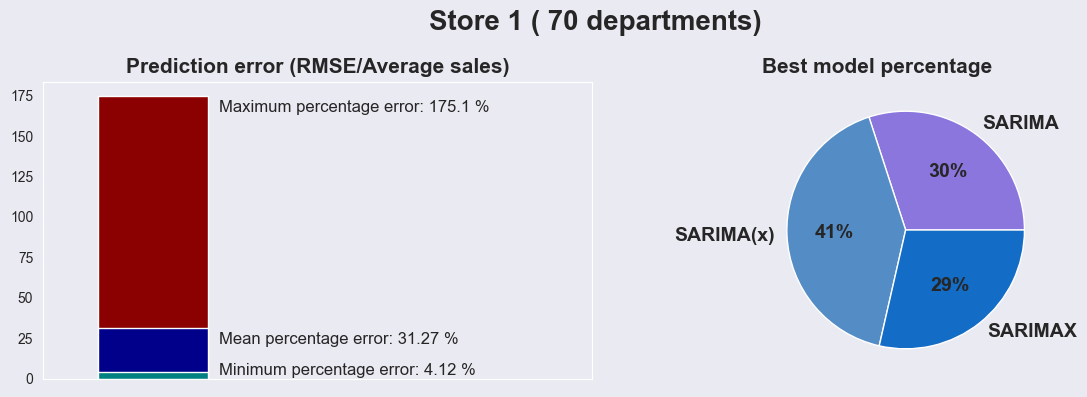

In [524]:

sns.set_style('dark')
fig=plt.figure(figsize=(12,4))
fig.patch.set_facecolor('#EAEAF2')
plt.subplot(121)
plt.title('Prediction error (RMSE/Average sales)',fontsize=15,fontweight='semibold')
plt.bar(0,store_stats['mean_error'].max(),color='darkred',width=0.5)
plt.text(0.3,store_stats['mean_error'].max()-10,f'Maximum percentage error: {store_stats['mean_error'].max()} %',fontsize=12)

plt.bar(0,store_stats['mean_error'].mean(),color='darkblue',width=0.5)
plt.text(0.3,store_stats['mean_error'].mean()-10,f'Mean percentage error: {round(store_stats['mean_error'].mean(),2)} %',fontsize=12)

plt.bar(0,store_stats['mean_error'].min(),color='teal',width=0.5)
plt.text(0.3,store_stats['mean_error'].min()-2,f'Minimum percentage error: {store_stats['mean_error'].min()} %',fontsize=12)

plt.xlim(-0.5,2)

plt.xticks([])

plt.subplot(122)
plt.title('Best model percentage          ',fontsize=15,fontweight='semibold')
plt.pie(store_stats['type'].value_counts().sort_index(),labels=store_stats['type'].value_counts().sort_index().index,
        colors=['#8B76DE','#548CC6','#136CC5'],
        autopct='%1.0f%%', pctdistance=0.6, textprops={'fontsize': 14,'fontweight':'semibold'})

plt.suptitle(f'Store 1 ( {store_stats.shape[0]} departments)',fontsize=20,fontweight='semibold')

plt.tight_layout()
plt.show()

In [528]:
store_stats.loc[(store_stats['mean_error']==store_stats['mean_error'].min()) |
                (store_stats['mean_error']==store_stats['mean_error'].max())]

,Store,Dept,SARIMA_RMSE,SARIMAX_RMSE,best,mean_error,type
52,1,59,1502.0,1758.0,SARIMA,175.10,SARIMA(x)
71,1,95,5220.0,4979.0,SARIMAX,4.12,SARIMAX


In [551]:

def prediction_plot_stores(department,store_number):

    model_type=store_stats.loc[store_stats['Dept']==department]['type'].values[0]

    if model_type == 'SARIMA':
        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model']

        X=df.loc[(df['Store']==store_number) & (df['Dept']==department)]\
            [['Date','Weekly_Sales']]
        X=X.set_index('Date')

        y_historical=X.loc[X.index<'2011-11-01']['Weekly_Sales']
        y_forecast=X.loc[X.index>'2011-11-01']['Weekly_Sales']

        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model'].values[0]

        sarima_pred=smodel.predict(n_periods=len(y_forecast))
        sarima_pred=pd.Series(sarima_pred, index=y_forecast.index)

        plt.figure(figsize=(12,5))
        plt.plot(y_historical,'teal',label='Historical')
        plt.plot(y_forecast,'teal',alpha=0.4)
        plt.plot(sarima_pred,'--',label='Prediction')
        plt.ylabel('Weekly Sales')
        plt.legend(fontsize=12)
        plt.title(f'Department {department} - Store {store_number} (Best model: {model_type})',fontsize=15, fontweight='semibold')   
        plt.tight_layout()     
        plt.show()        

    else:
        
        i=store_stats.loc[(store_stats['Dept']==department)].index.values[0]
        corr_feats=[]
        if models_selection.loc[i]['Holiday_corr']==1:
            corr_feats.append('IsHoliday')

        if models_selection.loc[i]['Temp_corr']==1:
            corr_feats.append('Temperature')

        if models_selection.loc[i]['CPI_corr']==1:
            corr_feats.append('CPI')
        
        if models_selection.loc[i]['FuelPrice_corr']==1:
            corr_feats.append('Fuel_Price')
        
        if models_selection.loc[i]['Unemployment_corr']==1:
            corr_feats.append('Unemployment')

        X=df.loc[(df['Store']==store_number) & 
                (df['Dept']==department)][['Date','Weekly_Sales']+corr_feats]
        X=X.set_index('Date') 

        X_historical=X.loc[X.index<'2011-11-01']
        X_forecast=X.loc[X.index>'2011-11-01']

        y_historical=X_historical['Weekly_Sales']
        y_forecast=X_forecast['Weekly_Sales']

        X_historical=X_historical.drop('Weekly_Sales',axis=1)
        X_forecast=X_forecast.drop('Weekly_Sales',axis=1)

        smodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMA_model'].values[0]
        sxmodel=models_selection.loc[(models_selection['Store']==store_number) & (models_selection['Dept']==department),'SARIMAX_model'].values[0]

        sarima_pred=smodel.predict(n_periods=len(y_forecast))
        sarimax_pred=sxmodel.predict(n_periods=len(y_forecast),X=X_forecast)

        sarima_pred = pd.Series(sarima_pred, index=y_forecast.index)
        sarimax_pred = pd.Series(sarimax_pred, index=y_forecast.index)

        if model_type == 'SARIMA(x)':

            plt.figure(figsize=(12,5))
            plt.plot(y_historical,'teal',label='Historical')
            plt.plot(y_forecast,'teal',alpha=0.6)
            plt.plot(sarima_pred,'--',label='Prediction (SARIMA)',color='darkblue')
            plt.plot(sarimax_pred,'--',label='Prediction (SARIMAX)',alpha=0.4,color='darkblue')
            plt.ylabel('Weekly Sales')
            plt.legend(fontsize=12)
            plt.title(f'Department {department} - Store {store_number} (Best model: SARIMA)',fontsize=15, fontweight='semibold')   
            plt.tight_layout()     
            plt.show()  

        else:

            plt.figure(figsize=(12,5))
            plt.plot(y_historical,'teal',label='Historical')
            plt.plot(y_forecast,'teal',alpha=0.6)
            plt.plot(sarimax_pred,'--',label='Prediction (SARIMAX)',color='darkblue')
            plt.plot(sarima_pred,'--',label='Prediction (SARIMA)',alpha=0.4,color='darkblue')
            plt.ylabel('Weekly Sales')
            plt.legend(fontsize=12)
            plt.title(f'Department {department} - Store {store_number} (Best model: SARIMAX)',fontsize=15, fontweight='semibold')   
            plt.tight_layout()     
            plt.show() 

71


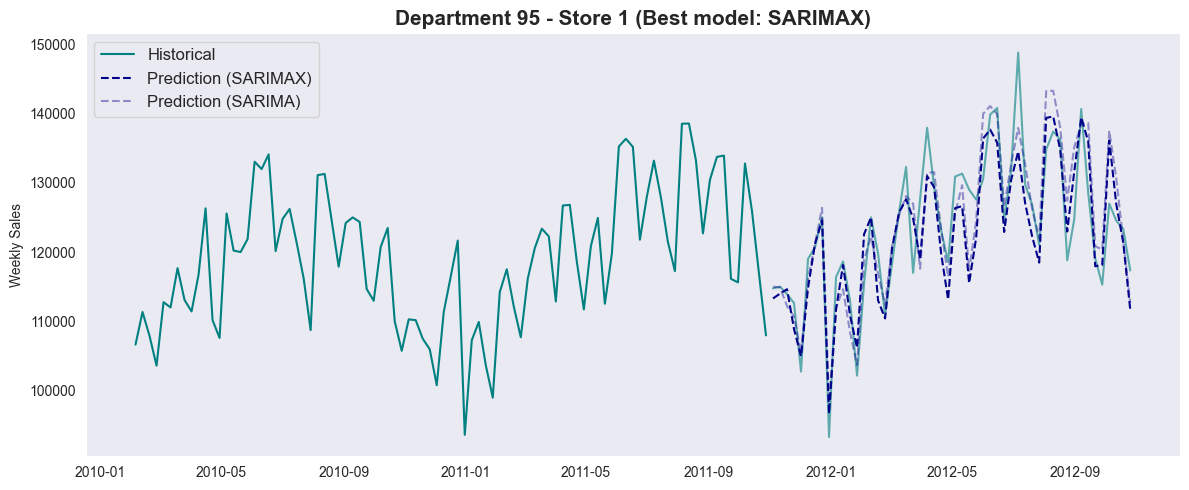

In [489]:
prediction_plot_stores(department=95,store_number=1)

In [584]:
models_selection.loc[71]

Store                                                  1
Dept                                                  95
p_val_Holiday                                      0.242
p_val_temp                                           0.0
p_val_CPI                                            0.0
p_val_FuelPrice                                      0.0
p_val_Unemployment                                 0.523
Holiday_corr                                           0
Temp_corr                                              1
CPI_corr                                               1
FuelPrice_corr                                         1
Unemployment_corr                                      0
count_corr                                             3
SARIMA_model           ARIMA(0,0,0)(0,1,0)[52] intercept
SARIMA_pred                                          NaN
SARIMA_RMSE                                       5220.0
SARIMAX_model          ARIMA(0,0,0)(0,1,0)[52]          
SARIMAX_pred                   

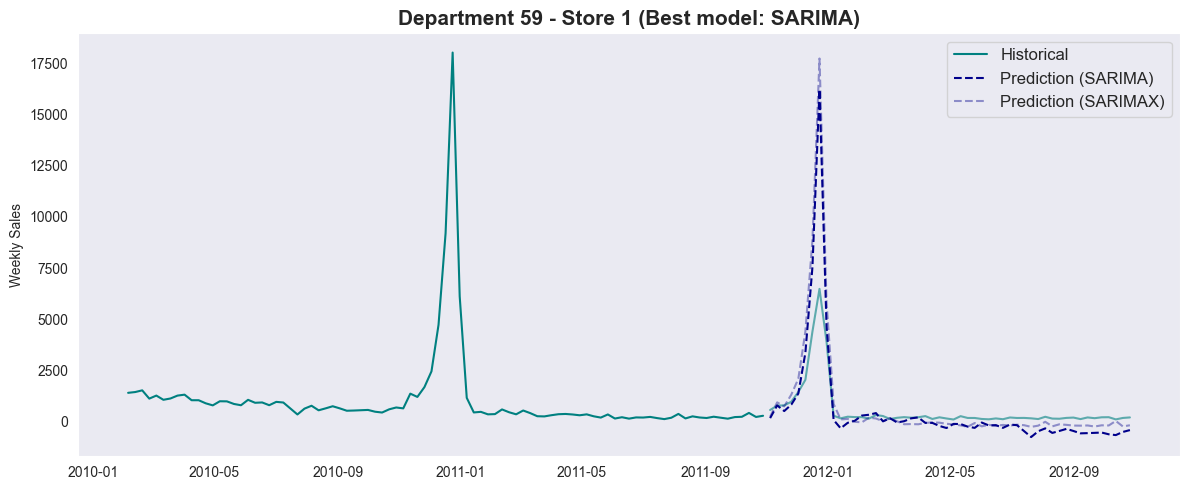

In [552]:
prediction_plot_stores(department=59,store_number=1)

In [616]:
smodel=models_selection.loc[(models_selection['Store']==1) & (models_selection['Dept']==59),'SARIMA_model']

X=df.loc[(df['Store']==1) & (df['Dept']==59)]\
[['Date','Weekly_Sales']]
X=X.set_index('Date')

print(X.loc[X.Weekly_Sales==X.Weekly_Sales.max()])
print(X.loc[(X.index > '2011-11-01')]['Weekly_Sales'].max())

            Weekly_Sales
Date                    
2010-12-24      18016.74
6483.26
